In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc, math

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [2]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set(style="whitegrid")

In [3]:
%%time
#in kaggle competition, if we want to run here, need to change the path of the data
metadata_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')
train_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/train.csv', parse_dates=['timestamp'])
test_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv', parse_dates=['timestamp'])
weather_train_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv', parse_dates=['timestamp'])
weather_test_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv', parse_dates=['timestamp'])

CPU times: user 49 s, sys: 6.38 s, total: 55.3 s
Wall time: 1min 11s


In [4]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [5]:
weather_train_df.shape

(139773, 9)

In [6]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01
1,1,1,0,2017-01-01
2,2,2,0,2017-01-01
3,3,3,0,2017-01-01
4,4,4,0,2017-01-01


In [7]:
weather = pd.concat([weather_train_df,weather_test_df],ignore_index=True)
weather_key = ['site_id', 'timestamp']

temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()

# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

In [8]:
weather_train_df.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6
139772,15,2016-12-31 23:00:00,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


In [9]:
weather_train_df = timestamp_align(weather_train_df)
weather_test_df = timestamp_align(weather_test_df)

In [10]:
del weather 
del df_2d
del temp_skeleton
del site_ids_offsets

In [11]:
weather_train_df.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
139768,15,2016-12-31 13:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7,6
139769,15,2016-12-31 14:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7,6
139770,15,2016-12-31 15:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1,6
139771,15,2016-12-31 16:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6,6
139772,15,2016-12-31 17:00:00,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8,6


### Fill NaNs in weather data by interpolation

In [12]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
offset                    0
dtype: int64

In [13]:
weather_test_df.isna().sum()

site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
offset                     0
dtype: int64

In [14]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [15]:
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [16]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        17228
dew_temperature           0
precip_depth_1_hr     26273
sea_level_pressure     8755
wind_direction            0
wind_speed                0
offset                    0
dtype: int64

In [17]:
weather_test_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        33146
dew_temperature           0
precip_depth_1_hr     51807
sea_level_pressure    17241
wind_direction            0
wind_speed                0
offset                    0
dtype: int64

In [18]:
train_df['meter_reading'] = np.log1p(train_df['meter_reading'])

In [19]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,5
1,0,2015-12-31 20:00:00,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5,5
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,5
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,5
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,5


In [20]:
## Function to reduce the memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [21]:
le = LabelEncoder()
metadata_df['primary_use'] = le.fit_transform(metadata_df['primary_use'])

In [22]:
metadata_df = reduce_mem_usage(metadata_df)
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)

Mem. usage decreased to  0.02 Mb (74.9% reduction)
Mem. usage decreased to 250.63 Mb (59.4% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.20 Mb (70.0% reduction)
Mem. usage decreased to  6.35 Mb (70.0% reduction)


#### Get insights of shapes and first few data rows of all the files

In [23]:
print (f'Training data shape: {train_df.shape}')
print (f'Weather training shape: {weather_train_df.shape}')
print (f'Weather training shape: {weather_test_df.shape}')
print (f'Weather testing shape: {metadata_df.shape}')
print (f'Test data shape: {test_df.shape}')

Training data shape: (20216100, 4)
Weather training shape: (139773, 10)
Weather training shape: (277243, 10)
Weather testing shape: (1449, 6)
Test data shape: (41697600, 4)


In [24]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [25]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
0,0,2015-12-31 19:00:00,25.000000,6.0,20.00000,-1.0,1019.5,0.0,0.000000,5
1,0,2015-12-31 20:00:00,24.406250,4.0,21.09375,-1.0,1020.0,70.0,1.500000,5
2,0,2015-12-31 21:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000,5
3,0,2015-12-31 22:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000,5
4,0,2015-12-31 23:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609,5


In [26]:
metadata_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


In [27]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01
1,1,1,0,2017-01-01
2,2,2,0,2017-01-01
3,3,3,0,2017-01-01
4,4,4,0,2017-01-01


In [28]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [29]:
%%time
full_train_df = train_df.merge(metadata_df, on='building_id', how='left')
full_train_df = full_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

CPU times: user 6.78 s, sys: 5.42 s, total: 12.2 s
Wall time: 10.6 s


Drop all NaN rows which are generated by timestamp alignment

In [30]:
full_train_df = full_train_df.loc[~(full_train_df['air_temperature'].isnull() & full_train_df['cloud_coverage'].isnull() & full_train_df['dew_temperature'].isnull() & full_train_df['precip_depth_1_hr'].isnull() & full_train_df['sea_level_pressure'].isnull() & full_train_df['wind_direction'].isnull() & full_train_df['wind_speed'].isnull() & full_train_df['offset'].isnull())]

In [31]:
full_train_df.shape

(20112649, 17)

#### Reducing the memory usage
Let's delete unnecessary dataframes from memory to lower the memory usage

In [32]:
# Delete unnecessary dataframes to decrease memory usage
del train_df
del weather_train_df
gc.collect()

0

Now let's change the data types of necessary feature columns based on the range of the data values. This will lower the data usage. But **how**? Let's see. For example the datatype of feature `building_id` is `int64` but based on the range of this feature, it can be accomodated in lower range i.e. `int16`. So this will decrease the memory usage.

#### Let's do the same for test data

In [33]:
%%time
full_test_df = test_df.merge(metadata_df, on='building_id', how='left')
full_test_df = full_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')

CPU times: user 13.3 s, sys: 11.7 s, total: 25 s
Wall time: 22.3 s


In [34]:
full_test_df.shape

(41697600, 17)

#### Reducing the memory usage
Let's delete unnecessary dataframes from memory to lower the memory usage

In [35]:
# Delete unnecessary dataframes to decrease memory usage
del metadata_df
del weather_test_df
del test_df
gc.collect()

0

In [36]:
full_train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
0,0,0,2016-01-01,0.0,0,0,7432,2008.0,NaN,19.40625,4.0,19.40625,0.0,1019.5,0.0,0.0,5.0
1,1,0,2016-01-01,0.0,0,0,2720,2004.0,NaN,19.40625,4.0,19.40625,0.0,1019.5,0.0,0.0,5.0
2,2,0,2016-01-01,0.0,0,0,5376,1991.0,NaN,19.40625,4.0,19.40625,0.0,1019.5,0.0,0.0,5.0
3,3,0,2016-01-01,0.0,0,0,23685,2002.0,NaN,19.40625,4.0,19.40625,0.0,1019.5,0.0,0.0,5.0
4,4,0,2016-01-01,0.0,0,0,116607,1975.0,NaN,19.40625,4.0,19.40625,0.0,1019.5,0.0,0.0,5.0


### Distribition of primary usage of buildings

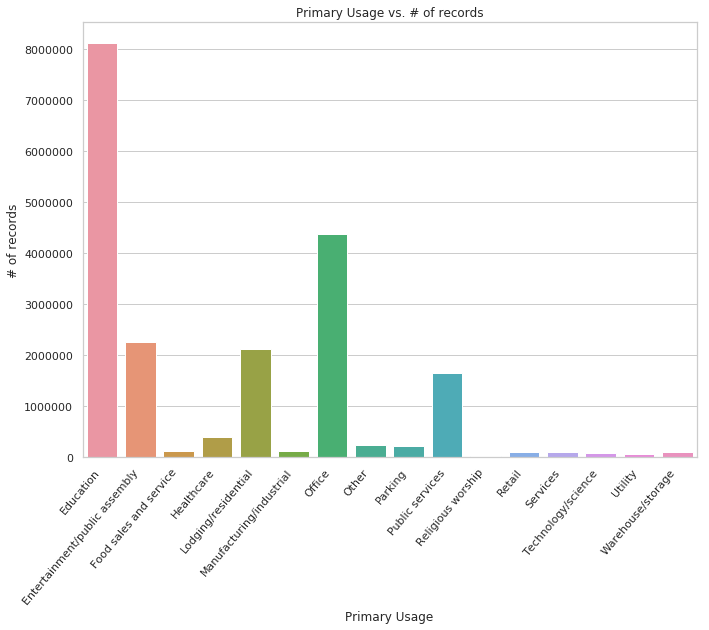

In [37]:
ax = sns.barplot(le.inverse_transform(full_train_df.groupby(['primary_use']).size().reset_index(name='counts')['primary_use']), full_train_df.groupby(['primary_use']).size().reset_index(name='counts')['counts'])
ax.set(xlabel='Primary Usage', ylabel='# of records', title='Primary Usage vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

### Distribution of meter types

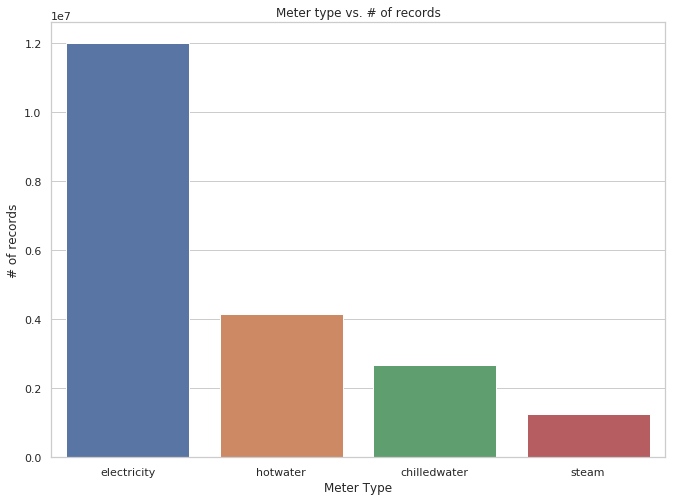

In [38]:
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
ax = sns.barplot(np.vectorize(meter_types.get)(pd.unique(full_train_df['meter'])), full_train_df['meter'].value_counts())
ax.set(xlabel='Meter Type', ylabel='# of records', title='Meter type vs. # of records')
plt.show()

### Average meter reading for training dataset

In [39]:
# Average meter reading
print (f'Average meter reading: {full_train_df.meter_reading.mean()} kWh')

Average meter reading: nan kWh


### Distribution of meter readings for each meter type

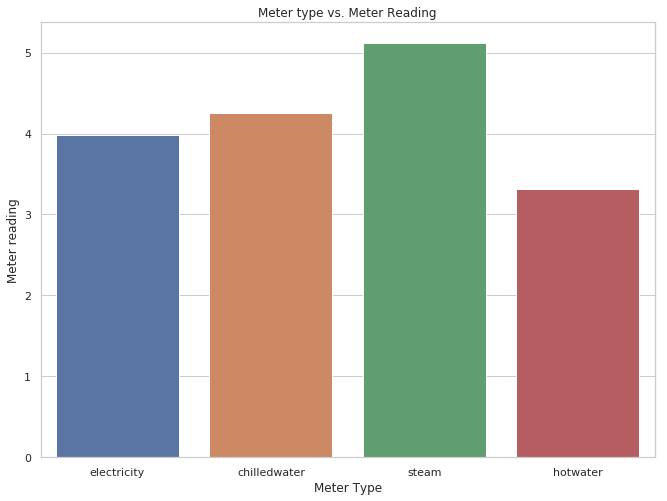

In [40]:
ax = sns.barplot(np.vectorize(meter_types.get)(full_train_df.groupby(['meter'])['meter_reading'].mean().keys()), full_train_df.groupby(['meter'])['meter_reading'].mean())
ax.set(xlabel='Meter Type', ylabel='Meter reading', title='Meter type vs. Meter Reading')
plt.show()

### Distribution of buildings built in each year for both training and test datasets

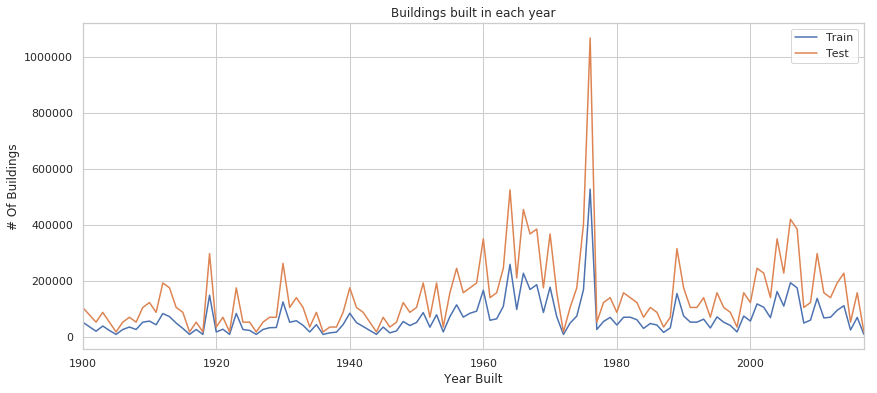

In [41]:
fig, ax = plt.subplots(1,1,figsize=(14, 6))
ax.set(xlabel='Year Built', ylabel='# Of Buildings', title='Buildings built in each year')
full_train_df['year_built'].value_counts(dropna=False).sort_index().plot(ax=ax)
full_test_df['year_built'].value_counts(dropna=False).sort_index().plot(ax=ax)
ax.legend(['Train', 'Test']);

### Distribution of square feet area of buildings

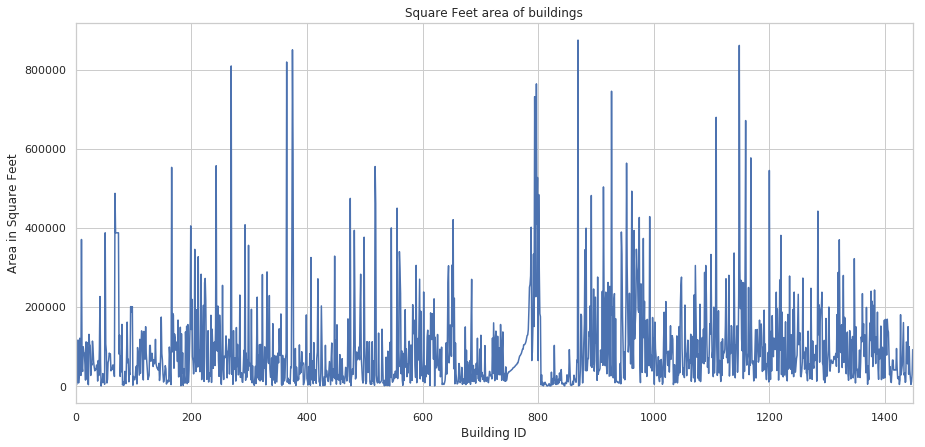

In [42]:
fig, ax = plt.subplots(1,1,figsize=(15, 7))
full_train_df.groupby(['building_id'])['square_feet'].mean().plot(ax=ax)
ax.set(xlabel='Building ID', ylabel='Area in Square Feet', title='Square Feet area of buildings')
plt.show()

## Feature Engineering

### Analysing missing data
First let's count and fill missing data in training datasets

In [43]:
pd.DataFrame(full_train_df.isna().sum().sort_values(ascending=False), columns=['NaN Count'])

,NaN Count
floor_count,16618674
year_built,12105206
precip_depth_1_hr,1646098
sea_level_pressure,779195
cloud_coverage,476553
primary_use,0
meter,0
timestamp,0
meter_reading,0
site_id,0


In [44]:
def mean_without_overflow_fast(col):
    col /= len(col)
    return col.mean() * len(col)

In [45]:
missing_values = (100-full_train_df.count() / len(full_train_df) * 100).sort_values(ascending=False)

In [46]:
%%time
missing_features = full_train_df.loc[:, missing_values > 0.0]
missing_features = missing_features.apply(mean_without_overflow_fast)

CPU times: user 942 ms, sys: 1.04 s, total: 1.99 s
Wall time: 1.6 s


In [47]:
for key in full_train_df.loc[:, missing_values > 0.0].keys():
    if key == 'year_built' or key == 'floor_count':
        full_train_df[key].fillna(math.floor(missing_features[key]), inplace=True)
        full_test_df[key].fillna(math.floor(missing_features[key]), inplace=True)
    else:
        full_train_df[key].fillna(missing_features[key], inplace=True)
        full_test_df[key].fillna(missing_features[key], inplace=True)

In [48]:
full_train_df.tail()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
20215251,1064,0,2016-12-31 23:00:00,5.042969,12,0,131212,1968.0,4.0,6.5,8.0,5.300781,1.255859,1019.5,340.0,6.0,0.0
20215252,1065,0,2016-12-31 23:00:00,1.827148,12,6,12152,1968.0,4.0,6.5,8.0,5.300781,1.255859,1019.5,340.0,6.0,0.0
20215253,1066,0,2016-12-31 23:00:00,3.291016,12,0,55800,1968.0,4.0,6.5,8.0,5.300781,1.255859,1019.5,340.0,6.0,0.0
20215254,1067,0,2016-12-31 23:00:00,5.445312,12,0,125701,1968.0,4.0,6.5,8.0,5.300781,1.255859,1019.5,340.0,6.0,0.0
20215255,1068,0,2016-12-31 23:00:00,4.050781,12,0,112956,1968.0,4.0,6.5,8.0,5.300781,1.255859,1019.5,340.0,6.0,0.0


In [49]:
full_test_df.tail()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
41697595,41697595,1444,0,2018-05-09 07:00:00,15,1,19619,1914.0,4.0,18.90625,0.0,10.601562,-1.0,1020.5,180.0,2.599609,6.0
41697596,41697596,1445,0,2018-05-09 07:00:00,15,0,4298,1968.0,4.0,18.90625,0.0,10.601562,-1.0,1020.5,180.0,2.599609,6.0
41697597,41697597,1446,0,2018-05-09 07:00:00,15,1,11265,1997.0,4.0,18.90625,0.0,10.601562,-1.0,1020.5,180.0,2.599609,6.0
41697598,41697598,1447,0,2018-05-09 07:00:00,15,4,29775,2001.0,4.0,18.90625,0.0,10.601562,-1.0,1020.5,180.0,2.599609,6.0
41697599,41697599,1448,0,2018-05-09 07:00:00,15,6,92271,2001.0,4.0,18.90625,0.0,10.601562,-1.0,1020.5,180.0,2.599609,6.0


### Adding few more features

In [50]:
full_train_df['timestamp'].dtype

dtype('<M8[ns]')

In [51]:
full_train_df["timestamp"] = pd.to_datetime(full_train_df["timestamp"])
full_test_df["timestamp"] = pd.to_datetime(full_test_df["timestamp"])

In [52]:
def transform(df):
    df['hour'] = np.uint8(df['timestamp'].dt.hour)
    df['day'] = np.uint8(df['timestamp'].dt.day)
    df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
    df['month'] = np.uint8(df['timestamp'].dt.month)
    df['year'] = np.uint8(df['timestamp'].dt.year-1900)
    
    df['square_feet'] = np.log(df['square_feet'])
    
    return df

In [53]:
full_train_df = transform(full_train_df)
full_test_df = transform(full_test_df)

In [54]:
def encode_cyclic_feature(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
#     df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    del df[col]
    return df

In [55]:
full_train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset,hour,day,weekday,month,year
0,0,0,2016-01-01,0.0,0,0,8.913550,2008.0,4.0,19.40625,...,0.0,1019.5,0.0,0.0,5.0,0,1,4,1,116
1,1,0,2016-01-01,0.0,0,0,7.908387,2004.0,4.0,19.40625,...,0.0,1019.5,0.0,0.0,5.0,0,1,4,1,116
2,2,0,2016-01-01,0.0,0,0,8.589700,1991.0,4.0,19.40625,...,0.0,1019.5,0.0,0.0,5.0,0,1,4,1,116
3,3,0,2016-01-01,0.0,0,0,10.072597,2002.0,4.0,19.40625,...,0.0,1019.5,0.0,0.0,5.0,0,1,4,1,116
4,4,0,2016-01-01,0.0,0,0,11.666565,1975.0,4.0,19.40625,...,0.0,1019.5,0.0,0.0,5.0,0,1,4,1,116


In [56]:
dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
full_train_df['is_holiday'] = (full_train_df['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
full_test_df['is_holiday'] = (full_test_df['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

In [57]:
# Assuming 5 days a week for all the given buildings
full_train_df.loc[(full_train_df['weekday'] == 5) | (full_train_df['weekday'] == 6) , 'is_holiday'] = 1
full_test_df.loc[(full_test_df['weekday']) == 5 | (full_test_df['weekday'] == 6) , 'is_holiday'] = 1

In [58]:
# full_train_df.loc[(full_train_df['primary_use'] == le.transform(['Education'])[0]) & (full_train_df['month'] >= 6) & (full_train_df['month'] <= 8), 'is_vacation_month'] = np.int8(1)
# full_train_df.loc[full_train_df['is_vacation_month']!=1, 'is_vacation_month'] = np.int8(0)

### Removing weired data on site_id 0

In [59]:
full_train_df.shape

(20112649, 23)

In [60]:
full_train_df = full_train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [61]:
full_train_df.shape

(19766435, 23)

In [62]:
full_test_df = full_test_df.drop(['timestamp'], axis=1)
full_train_df = full_train_df.drop(['timestamp'], axis=1)
print (f'Shape of training dataset: {full_train_df.shape}')
print (f'Shape of testing dataset: {full_test_df.shape}')

Shape of training dataset: (19766435, 22)
Shape of testing dataset: (41697600, 22)


In [63]:
full_train_df.tail()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,sea_level_pressure,wind_direction,wind_speed,offset,hour,day,weekday,month,year,is_holiday
20215251,1064,0,5.042969,12,0,11.784570,1968.0,4.0,6.5,8.0,...,1019.5,340.0,6.0,0.0,23,31,5,12,116,1
20215252,1065,0,1.827148,12,6,9.405249,1968.0,4.0,6.5,8.0,...,1019.5,340.0,6.0,0.0,23,31,5,12,116,1
20215253,1066,0,3.291016,12,0,10.929529,1968.0,4.0,6.5,8.0,...,1019.5,340.0,6.0,0.0,23,31,5,12,116,1
20215254,1067,0,5.445312,12,0,11.741661,1968.0,4.0,6.5,8.0,...,1019.5,340.0,6.0,0.0,23,31,5,12,116,1
20215255,1068,0,4.050781,12,0,11.634754,1968.0,4.0,6.5,8.0,...,1019.5,340.0,6.0,0.0,23,31,5,12,116,1


In [64]:
full_train_df.tail()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,sea_level_pressure,wind_direction,wind_speed,offset,hour,day,weekday,month,year,is_holiday
20215251,1064,0,5.042969,12,0,11.784570,1968.0,4.0,6.5,8.0,...,1019.5,340.0,6.0,0.0,23,31,5,12,116,1
20215252,1065,0,1.827148,12,6,9.405249,1968.0,4.0,6.5,8.0,...,1019.5,340.0,6.0,0.0,23,31,5,12,116,1
20215253,1066,0,3.291016,12,0,10.929529,1968.0,4.0,6.5,8.0,...,1019.5,340.0,6.0,0.0,23,31,5,12,116,1
20215254,1067,0,5.445312,12,0,11.741661,1968.0,4.0,6.5,8.0,...,1019.5,340.0,6.0,0.0,23,31,5,12,116,1
20215255,1068,0,4.050781,12,0,11.634754,1968.0,4.0,6.5,8.0,...,1019.5,340.0,6.0,0.0,23,31,5,12,116,1


In [65]:
## Reducing memory
full_train_df = reduce_mem_usage(full_train_df)
full_test_df = reduce_mem_usage(full_test_df)
gc.collect()

Mem. usage decreased to 810.58 Mb (21.8% reduction)
Mem. usage decreased to 1789.47 Mb (21.1% reduction)


11247

In [66]:
beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    full_train_df.loc[(full_train_df['wind_speed']>=item[1]) & (full_train_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

In [67]:
full_train_df['group'] = full_train_df['month']
full_train_df['group'].replace((1,2,3,4,5,6), 1,inplace=True)
full_train_df['group'].replace((7,8,9,10,11,12), 2, inplace=True)

In [68]:
full_train_df = encode_cyclic_feature(full_train_df, 'weekday', 7)
full_train_df = encode_cyclic_feature(full_train_df, 'hour', 24)
full_train_df = encode_cyclic_feature(full_train_df, 'day', 31)
full_train_df = encode_cyclic_feature(full_train_df, 'month', 12)

In [69]:
full_train_df = reduce_mem_usage(full_train_df)

Mem. usage decreased to 942.54 Mb (42.5% reduction)


In [70]:
categoricals = ['site_id', 'building_id', 'primary_use', 'meter',  'wind_direction', 'is_holiday']
drop_cols = ['sea_level_pressure', 'wind_speed']
numericals = ['square_feet', 'year_built', 'air_temperature', 'cloud_coverage',
              'dew_temperature', 'precip_depth_1_hr', 'floor_count', 'beaufort_scale', 'weekday_sin', 'day_sin', 'hour_sin', 'month_sin']

feat_cols = categoricals + numericals

In [71]:
full_train_df.tail()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,wind_speed,offset,year,is_holiday,beaufort_scale,group,weekday_sin,hour_sin,day_sin,month_sin
20215251,1064,0,5.042969,12,0,11.781250,1968.0,4.0,6.5,8.0,...,6.0,0.0,116,1,4.0,2,-0.975098,-0.258789,-0.0,-0.0
20215252,1065,0,1.827148,12,6,9.406250,1968.0,4.0,6.5,8.0,...,6.0,0.0,116,1,4.0,2,-0.975098,-0.258789,-0.0,-0.0
20215253,1066,0,3.291016,12,0,10.929688,1968.0,4.0,6.5,8.0,...,6.0,0.0,116,1,4.0,2,-0.975098,-0.258789,-0.0,-0.0
20215254,1067,0,5.445312,12,0,11.742188,1968.0,4.0,6.5,8.0,...,6.0,0.0,116,1,4.0,2,-0.975098,-0.258789,-0.0,-0.0
20215255,1068,0,4.050781,12,0,11.632812,1968.0,4.0,6.5,8.0,...,6.0,0.0,116,1,4.0,2,-0.975098,-0.258789,-0.0,-0.0


In [72]:
full_train_df = reduce_mem_usage(full_train_df)
gc.collect()

Mem. usage decreased to 942.54 Mb (0.0% reduction)


0

In [73]:
target = full_train_df["meter_reading"]
del full_train_df["meter_reading"]

In [74]:
full_train_df.drop(drop_cols, axis=1)
gc.collect()

0

In [75]:
# Save the testing dataset to freeup the RAM. We'll read after training
# full_test_df.to_pickle('full_test_df.pkl')
# del full_test_df
# gc.collect()

In [76]:
full_train_df.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,...,wind_speed,offset,year,is_holiday,beaufort_scale,group,weekday_sin,hour_sin,day_sin,month_sin
103,105,0,1,0,10.835938,1968.0,5.0,3.800781,0.0,2.400391,...,3.099609,0.0,116,1,2.0,1,-0.433838,0.0,0.201294,0.5
104,106,0,1,0,8.585938,1968.0,4.0,3.800781,0.0,2.400391,...,3.099609,0.0,116,1,2.0,1,-0.433838,0.0,0.201294,0.5
105,106,3,1,0,8.585938,1968.0,4.0,3.800781,0.0,2.400391,...,3.099609,0.0,116,1,2.0,1,-0.433838,0.0,0.201294,0.5
106,107,0,1,0,11.484375,2005.0,10.0,3.800781,0.0,2.400391,...,3.099609,0.0,116,1,2.0,1,-0.433838,0.0,0.201294,0.5
107,108,0,1,0,11.312500,1913.0,5.0,3.800781,0.0,2.400391,...,3.099609,0.0,116,1,2.0,1,-0.433838,0.0,0.201294,0.5


In [77]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.4,
            'subsample_freq': 1,
            'learning_rate': 0.25,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'lambda_l1': 1,
            'lambda_l2': 1
            }

folds = 2
seed = 666

# kf = StratifiedKFold(n_splits=folds, shuffle=False, random_state=seed)

# models = []
# for train_index, val_index in kf.split(full_train_df, full_train_df['building_id']):
#     train_X = full_train_df[feat_cols].iloc[train_index]
#     val_X = full_train_df[feat_cols].iloc[val_index]
#     train_y = target.iloc[train_index]
#     val_y = target.iloc[val_index]
#     lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
#     lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
#     gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=500,
#                 valid_sets=(lgb_train, lgb_eval),
#                 early_stopping_rounds=100,
#                 verbose_eval = 100)
#     models.append(gbm)
kf = GroupKFold(n_splits=folds)

models = []
for train_index, val_index in kf.split(full_train_df, full_train_df['building_id'], groups=full_train_df['group']):
#     train_X, train_y = full_train_df[feat_cols].loc[train_index], full_train_df['meter_reading'][train_index]
#     val_X, val_y = full_train_df[feat_cols].loc[val_index], full_train_df['meter_reading'][val_index]
    train_X = full_train_df[feat_cols].iloc[train_index]
    val_X = full_train_df[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=100,
                verbose_eval = 100)
    models.append(gbm)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.860924	valid_1's rmse: 1.1908
[200]	training's rmse: 0.798752	valid_1's rmse: 1.18634
[300]	training's rmse: 0.769253	valid_1's rmse: 1.18272
[400]	training's rmse: 0.746902	valid_1's rmse: 1.1821
Early stopping, best iteration is:
[349]	training's rmse: 0.758543	valid_1's rmse: 1.18162
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.904698	valid_1's rmse: 1.17205
[200]	training's rmse: 0.829832	valid_1's rmse: 1.16692
Early stopping, best iteration is:
[129]	training's rmse: 0.874455	valid_1's rmse: 1.16487


In [78]:
del full_train_df, train_X, val_X, lgb_train, lgb_eval, train_y, val_y, target
gc.collect()

411

In [79]:
# full_test_df = pd.read_pickle('full_test_df.pkl')

In [80]:
# full_test_df.loc[(full_test_df['primary_use'] == le.transform(['Education'])[0]) & (full_test_df['month'] >= 6) & (full_test_df['month'] <= 8), 'is_vacation_month'] = np.int8(1)
# full_test_df.loc[full_test_df['is_vacation_month']!=1, 'is_vacation_month'] = np.int8(0)

In [81]:
for item in beaufort:
    full_test_df.loc[(full_test_df['wind_speed']>=item[1]) & (full_test_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

In [82]:
full_test_df = encode_cyclic_feature(full_test_df, 'weekday', 7)
full_test_df = encode_cyclic_feature(full_test_df, 'hour', 24)
full_test_df = encode_cyclic_feature(full_test_df, 'day', 31)
full_test_df = encode_cyclic_feature(full_test_df, 'month', 12)

In [83]:
full_test_df = full_test_df[feat_cols]

In [84]:
full_test_df = reduce_mem_usage(full_test_df)

Mem. usage decreased to 1590.64 Mb (42.9% reduction)


In [85]:
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(full_test_df.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(full_test_df.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size

100%|██████████| 834/834 [07:21<00:00,  1.89it/s]


In [86]:
res = np.concatenate(res)

In [87]:
submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
submission['meter_reading'] = res
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
submission.to_csv('submission_fe_lgbm.csv', index=False)
submission

,row_id,meter_reading
0,0,122.945519
1,1,68.343653
2,2,11.108678
3,3,172.403901
4,4,801.693164
...,...,...
41697595,41697595,5.809766
41697596,41697596,4.114761
41697597,41697597,2.402474
41697598,41697598,168.788780
